In [2]:
import warnings
warnings.filterwarnings('ignore')

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from pathlib import Path
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import joblib

# Configuration
CSV_FILE = 'UGANDA_ROBUSTA_COFFEE_ULTIMATE_FULL_1961_2024.csv'
TARGET = 'Yield_kgha'
DATE_COL = 'Year'
TEST_YEAR_SPLIT = 2018  # train on years <= TEST_YEAR_SPLIT, test on > TEST_YEAR_SPLIT
RANDOM_STATE = 42


In [3]:
# 1. Load data
df = pd.read_csv(CSV_FILE)
df = df.sort_values(DATE_COL).reset_index(drop=True)
print(f'Loaded {len(df)} rows. Years {df[DATE_COL].min()}-{df[DATE_COL].max()}')
df.head()

Loaded 64 rows. Years 1961-2024


,Year,Production_1000t,Area_1000ha,Yield_kgha,Rainfall_mm,Temp_C,NDVI,Bearing_Trees_Millions,ONI_lagged9,Incidence_Index_pct,CWD_pct,BCTB_pct,Fertilizer_kgha,Soil_N_pct,Soil_P_ppm
0,1961,88.6,250,354.400000,1425,23.05,0.52,100.0,-0.15,2.0,0.0,0.0,1.2,0.205,10.5
1,1962,89.2,252,353.968254,1280,23.10,0.52,100.8,-0.20,2.0,0.0,0.0,1.2,0.205,10.5
2,1963,90.1,255,353.333333,1310,23.08,0.52,102.0,-0.10,2.0,0.0,0.0,1.2,0.204,10.4
3,1964,91.0,258,352.713178,1195,23.12,0.52,103.2,0.05,2.0,0.0,0.0,1.2,0.204,10.4
4,1965,92.0,260,353.846154,1150,23.15,0.52,104.0,0.15,2.0,0.0,0.0,1.2,0.203,10.3


In [4]:
# 2. Basic cleaning: ensure numeric types and report missing values
for col in df.columns:
    if col != DATE_COL:
        df[col] = pd.to_numeric(df[col], errors='coerce')

print('\nMissing values per column:')
print(df.isna().sum())

display(df.describe().T)



Missing values per column:
Year                      0
Production_1000t          0
Area_1000ha               0
Yield_kgha                0
Rainfall_mm               0
Temp_C                    0
NDVI                      0
Bearing_Trees_Millions    0
ONI_lagged9               0
Incidence_Index_pct       0
CWD_pct                   0
BCTB_pct                  0
Fertilizer_kgha           0
Soil_N_pct                0
Soil_P_ppm                0
dtype: int64


,count,mean,std,min,25%,50%,75%,max
Year,64.0,1992.500000,18.618987,1961.000000,1976.750000,1992.5000,2008.250000,2024.000000
Production_1000t,64.0,138.014062,71.083586,88.600000,103.750000,119.5000,135.250000,411.000000
Area_1000ha,64.0,303.984375,60.488879,170.000000,271.500000,311.0000,350.500000,390.000000
Yield_kgha,64.0,523.106746,494.886640,352.713178,358.504524,363.4952,367.444378,2417.647059
Rainfall_mm,64.0,1231.359375,60.618078,1080.000000,1198.750000,1232.5000,1261.250000,1425.000000
Temp_C,64.0,23.837500,0.465352,23.050000,23.442500,23.8350,24.227500,24.620000
NDVI,64.0,0.549219,0.035335,0.500000,0.520000,0.5400,0.570000,0.650000
Bearing_Trees_Millions,64.0,148.243750,67.643984,100.000000,115.800000,131.6000,147.400000,411.000000
ONI_lagged9,64.0,-0.296094,0.589815,-1.300000,-0.862500,-0.2000,0.200000,0.700000
Incidence_Index_pct,64.0,16.146875,18.706072,2.000000,2.000000,5.0000,30.000000,60.000000


In [5]:
# 4. Prepare features and target
features = [c for c in df.columns if c != TARGET]
print('Features used:')
print(features)

X = df[features].copy()
y = df[TARGET].copy()

Features used:
['Year', 'Production_1000t', 'Area_1000ha', 'Rainfall_mm', 'Temp_C', 'NDVI', 'Bearing_Trees_Millions', 'ONI_lagged9', 'Incidence_Index_pct', 'CWD_pct', 'BCTB_pct', 'Fertilizer_kgha', 'Soil_N_pct', 'Soil_P_ppm']


In [6]:
# 5. Time-aware train/test split (no shuffle)
train_mask = X[DATE_COL] <= TEST_YEAR_SPLIT
X_train = X.loc[train_mask].drop(DATE_COL, axis=1)
y_train = y.loc[train_mask]
X_test = X.loc[~train_mask].drop(DATE_COL, axis=1)
y_test = y.loc[~train_mask]

print(f"Train years: {int(df.loc[train_mask, DATE_COL].min())}-{int(df.loc[train_mask, DATE_COL].max())} ({len(X_train)})")
print(f"Test years:  {int(df.loc[~train_mask, DATE_COL].min())}-{int(df.loc[~train_mask, DATE_COL].max())} ({len(X_test)})")

Train years: 1961-2018 (58)
Test years:  2019-2024 (6)


In [7]:
# 6. Build and train pipeline: StandardScaler + LinearRegression
pipe = Pipeline([
    ('scaler', StandardScaler()),
    ('lr', LinearRegression())
])
pipe.fit(X_train, y_train)
y_pred = pipe.predict(X_test)

def metrics(y_true, y_pred):
    rmse = mean_squared_error(y_true, y_pred)
    mae = mean_absolute_error(y_true, y_pred)
    r2 = r2_score(y_true, y_pred)
    return {'rmse': rmse, 'mae': mae, 'r2': r2}

m = metrics(y_test, y_pred)
print('Linear Regression evaluation on test set:')
print(f"  RMSE: {m['rmse']:.3f}")
print(f"  MAE : {m['mae']:.3f}")
print(f"  R2  : {m['r2']:.3f}")

Linear Regression evaluation on test set:
  RMSE: 3993.881
  MAE : 48.488
  R2  : 0.979


Saved plot to actual_vs_predicted_linear.png


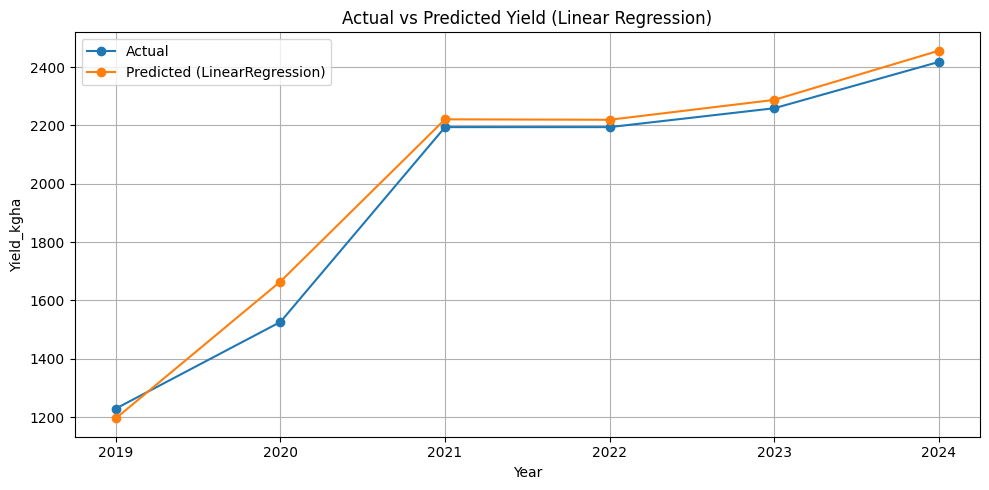

In [8]:
# 7. Plot Actual vs Predicted
years_test = df.loc[~train_mask, DATE_COL].astype(int).values
plt.figure(figsize=(10,5))
plt.plot(years_test, y_test.values, marker='o', label='Actual')
plt.plot(years_test, y_pred, marker='o', label='Predicted (LinearRegression)')
plt.xlabel('Year')
plt.ylabel('Yield_kgha')
plt.title('Actual vs Predicted Yield (Linear Regression)')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.savefig('actual_vs_predicted_linear.png', dpi=150)
print('Saved plot to actual_vs_predicted_linear.png')
plt.show()


In [9]:
# 8. Predictions table and save model
pred_df = pd.DataFrame({
    'Year': years_test,
    'Actual': y_test.values,
    'Predicted': np.round(y_pred, 2),
    'Error': np.round(y_pred - y_test.values, 2)
})
display(pred_df)

# Save fitted pipeline
out_path = Path('linear_regression_model.joblib')
joblib.dump(pipe, out_path)
print(f'Saved linear regression pipeline to: {out_path.resolve()}')

,Year,Actual,Predicted,Error
0,2019,1229.411765,1195.96,-33.46
1,2020,1526.315789,1664.90,138.58
2,2021,2194.117647,2220.84,26.72
3,2022,2194.117647,2219.29,25.17
4,2023,2258.823529,2287.47,28.64
5,2024,2417.647059,2456.00,38.36


Saved linear regression pipeline to: C:\Users\Administrator\linear_regression_model.joblib


In [14]:
from pathlib import Path
import joblib
import pandas as pd

# Path to the saved model
out_path = Path('linear_regression_model.joblib')

# Load the trained model
model = joblib.load(out_path)

# Get the feature names the model expects
feature_names = model.feature_names_in_

# Create future data for 2025 only
future_row = {col: df[col].mean() if col in df.columns else 0 for col in feature_names}
future_row['Year'] = 2025  # optional, if you want to keep the year column

# Convert into a DataFrame
future = pd.DataFrame([future_row])

# Make prediction
future['Predicted_Yield'] = model.predict(future[feature_names])

print(future)


   Production_1000t  Area_1000ha  Rainfall_mm   Temp_C      NDVI  \
0        138.014062   303.984375  1231.359375  23.8375  0.549219   

   Bearing_Trees_Millions  ONI_lagged9  Incidence_Index_pct  CWD_pct  \
0               148.24375    -0.296094            16.146875  8.63125   

   BCTB_pct  Fertilizer_kgha  Soil_N_pct  Soil_P_ppm  Year  Predicted_Yield  
0  5.289062          2.14375    0.193016    9.082812  2025          526.607  
